In [1]:
import os
import torch
import warnings
import seaborn as sns
from torchmetrics.functional.regression import cosine_similarity

from const import *
from data import get_dataloader

warnings.filterwarnings('ignore')

/opt/conda/envs/main/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/envs/main/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
test_file_name = "triplet_both_test_5k.txt"
test_file_path = os.path.join(data_dir, test_file_name)
test_dl = get_dataloader(test_file_path, "eval", batch_size=128)

5000it [00:00, 252243.44it/s]


In [3]:
def get_pairs_similarity(model, test_dl):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    # 计算pairs之间的相似度
    similarities_1 = []
    similarities_0 = []
    with torch.no_grad():
        for batch_idx, source in enumerate(test_dl):
            real_batch_num = source.get('input_ids').shape[0]
            input_ids = source.get('input_ids').view(real_batch_num * 3, -1).to(device)
            attention_mask = source.get('attention_mask').view(real_batch_num * 3, -1).to(device)
            token_type_ids = source.get('token_type_ids').view(real_batch_num * 3, -1).to(device)
            out = model(input_ids, attention_mask, token_type_ids)
            idx = torch.arange(out.shape[0], device=device).unsqueeze(1)
            # 三元组 (anchor, positive, negetive)
            anchor = out.index_select(0, torch.where(idx % 3 == 0)[0])
            positive = out.index_select(0, torch.where(idx % 3 == 1)[0])
            negative = out.index_select(0, torch.where(idx % 3 == 2)[0])

            # y_true、y_pred、y_prob
            sim_1 = cosine_similarity(anchor, positive, 'none').cpu().numpy()
            sim_0 = cosine_similarity(anchor, negative, 'none').cpu().numpy()
            similarities_1.extend(sim_1)
            similarities_0.extend(sim_0)
    return similarities_1, similarities_0

# Federated_GEAN_Sup-SimCSE

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

In [5]:
model_path = os.path.join(model_dir, "2022-06-03/Federated/Transformer+GE-type+Entity-Pooler/Sup-SimCSE/21:17:10-Federated_Transformer+GE-type+Entity-Pooler_Sup-SimCSE-global.pt")
model = torch.load(model_path)
GEAN_similarities_1, GEAN_similarities_0 = get_pairs_similarity(model, test_dl)

In [6]:
model_path = os.path.join(model_dir, "2022-06-03/Federated/Transformer/Sup-SimCSE/23:52:29-Federated_Transformer_Sup-SimCSE-global.pt")
model = torch.load(model_path)
Tran_similarities_1, Tran_similarities_0 = get_pairs_similarity(model, test_dl)

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


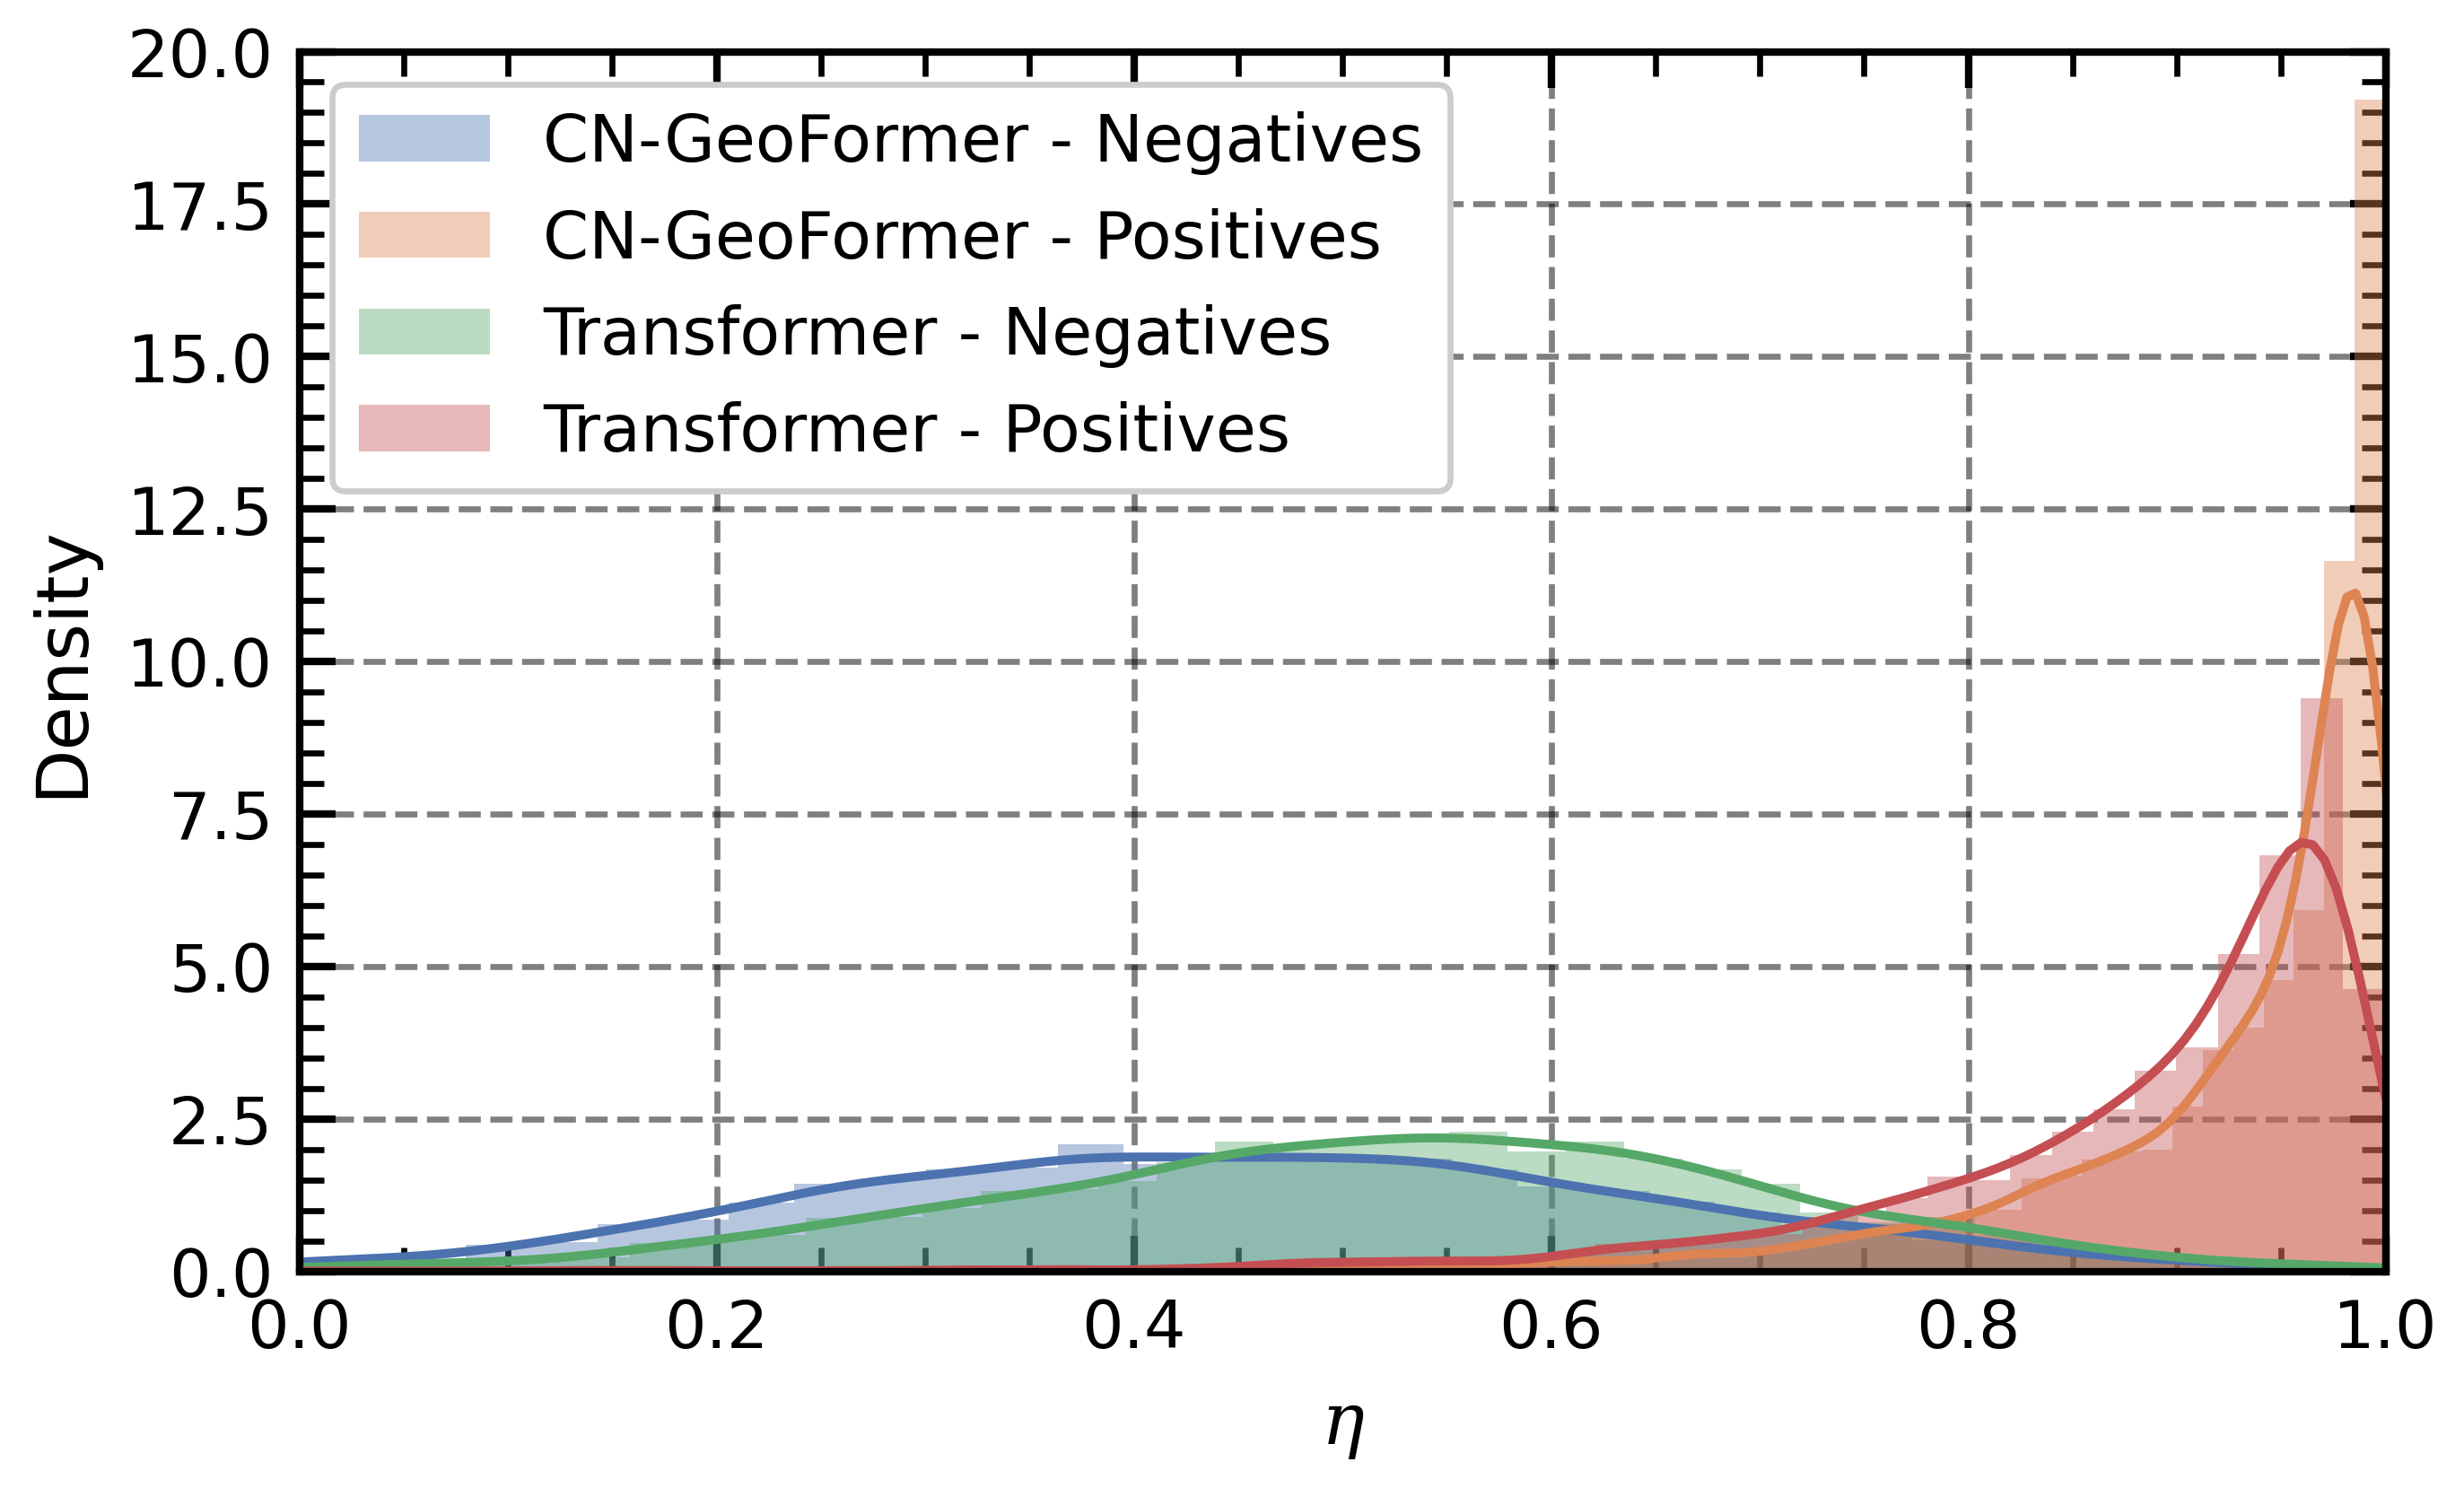

In [8]:
plt.style.use(['science', 'no-latex', 'grid', 'muted'])
# sns.set(style="whitegrid", color_codes=True)
sns.set_palette(sns.color_palette("deep"))
# sns.despine(right=False, top=True)
sns.set_context("paper")

plt.subplots(figsize=(5, 3))
sns.distplot(GEAN_similarities_0, label="CN-GeoFormer - Negatives")
sns.distplot(GEAN_similarities_1, label="CN-GeoFormer - Positives")
sns.distplot(Tran_similarities_0, label="Transformer - Negatives")
sns.distplot(Tran_similarities_1, label="Transformer - Positives")
plt.legend(loc='upper left')
plt.xlim(0, 1)
plt.ylim(0, 20)
plt.xlabel("$\eta$")
plt.ylabel("Density")
plt.savefig("figures/Cosine similarity distribution.pdf", dpi=300)

# Federated_GEAN_Sup-Triplet

In [7]:
model_path = os.path.join(model_dir, "2022-06-04/Federated/Transformer+GE-type+Entity-Pooler/Sup-Triplet/12:45:15-Federated_Transformer+GE-type+Entity-Pooler_Sup-Triplet-global.pt")
model = torch.load(model_path)
GEAN_triplet_similarities_1, GEAN_triplet_similarities_0 = get_pairs_similarity(model, test_dl)

In [8]:
model_path = os.path.join(model_dir, "2022-05-30/Federated/Transformer/Sup-Triplet/22:24:51-Federated_Transformer_Sup-Triplet-global.pt")
model = torch.load(model_path)
Tran_triplet_similarities_1, Tran_triplet_similarities_0 = get_pairs_similarity(model, test_dl)

In [9]:
model_path = os.path.join(model_dir, "2022-05-29/configs/global-4Transformer_Type-Sup_SimCSE-Federated-2022.05.29-13:26:13.pt")
model = torch.load(model_path)
TranG_similarities_1, TranG_similarities_0 = get_pairs_similarity(model, test_dl)

In [10]:
import collections
counter_1 = collections.Counter(Tran_triplet_similarities_1)
counter_0 = collections.Counter(Tran_triplet_similarities_0)
print(counter_1)
print(counter_0)

Counter({0.9999999: 3030, 1.0: 1550, 0.99999976: 380, 1.0000001: 40})
Counter({0.9999999: 2963, 1.0: 1641, 0.99999976: 348, 1.0000001: 48})


In [ ]:
sns.set(style="whitegrid", color_codes=True)
sns.set_palette(sns.color_palette("deep"))
sns.set_context("paper")
sns.despine(right=False, top=True)

plt.figure()
plt.subplots(figsize=(10, 6.18))
sns.distplot(GEAN_similarities_0, label="GEAN - Negatives")
sns.distplot(GEAN_similarities_1, label="GEAN - Positives")
sns.distplot(Tran_similarities_0, label="Transformer - Negatives")
sns.distplot(Tran_similarities_1, label="Transformer - Positives")
plt.legend(loc='upper left')
plt.xlim(0, 1)
plt.xlabel("cosine similarity")
plt.suptitle("Federated - Sup.SimCSE")
plt.savefig("figures/Federated_Sup.SimCSE.pdf", dpi=200)

# Residence

In [27]:
model_path = os.path.join(model_dir, "2022-06-04/Residence/Transformer+GE-type+Entity-Pooler/Sup-SimCSE/12:20:15-Residence_Transformer+GE-type+Entity-Pooler_Sup-SimCSE.pt")
model = torch.load(model_path)
Res_GEAN_similarities_1, Res_GEAN_similarities_0 = get_pairs_similarity(model, test_dl)

In [28]:
model_path = os.path.join(model_dir, "2022-06-03/Residence/Transformer/Sup-SimCSE/13:13:04-Residence_Transformer_Sup-SimCSE.pt")
model = torch.load(model_path)
Res_Tran_similarities_1, Res_Tran_similarities_0 = get_pairs_similarity(model, test_dl)

In [ ]:
plt.style.use(['science', 'ieee', 'no-latex'])
sns.set_context("paper")

plt.figure()
plt.subplots(figsize=(10, 6.18))
sns.distplot(Res_GEAN_similarities_0, label="GEAN - Negatives")
sns.distplot(Res_GEAN_similarities_1, label="GEAN - Positives")
sns.distplot(Res_Tran_similarities_0, label="Transformer - Negatives")
sns.distplot(Res_Tran_similarities_1, label="Transformer - Positives")
plt.legend(loc='upper left')
plt.xlim(0, 1)
plt.xlabel("cosine similarity")
plt.suptitle("Federated - Sup.SimCSE")
plt.savefig("figures/Residence_Sup.SimCSE.pdf", dpi=200)

Text(0.5, 0.98, 'cosine similarities of positives')

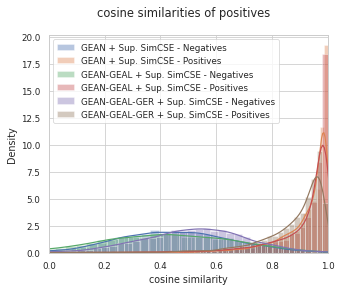

In [133]:
plt.subplots(figsize=(5,))
sns.distplot(GEAN_similarities_0, label="GEAN + Sup. SimCSE - Negatives")
sns.distplot(GEAN_similarities_1, label="GEAN + Sup. SimCSE - Positives")
sns.distplot(TranG_similarities_0, label="GEAN-GEAL + Sup. SimCSE - Negatives")
sns.distplot(TranG_similarities_1, label="GEAN-GEAL + Sup. SimCSE - Positives")
sns.distplot(Tran_similarities_0, label="GEAN-GEAL-GER + Sup. SimCSE - Negatives")
sns.distplot(Tran_similarities_1, label="GEAN-GEAL-GER + Sup. SimCSE - Positives")
plt.legend()
plt.xlim(0, 1)
plt.xlabel("cosine similarity")
plt.suptitle("cosine similarities of positives")

Text(0.5, 0.98, 'cosine similarities of positives')

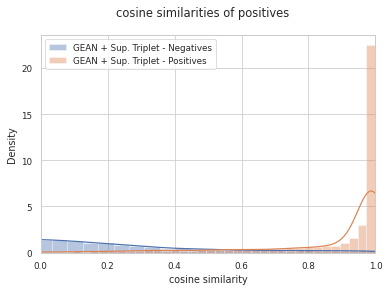

In [94]:
plt.subplots()
sns.distplot(GEAN_triplet_similarities_0, label="GEAN + Sup. Triplet - Negatives")
sns.distplot(GEAN_triplet_similarities_1, label="GEAN + Sup. Triplet - Positives")
plt.legend()
plt.xlim(0, 1)
plt.xlabel("cosine similarity")
plt.suptitle("cosine similarities of positives")

Text(0.5, 0.98, 'cosine similarities of positives')

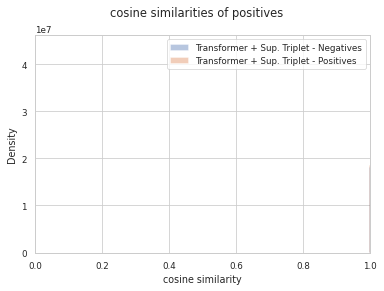

In [92]:
plt.subplots()
sns.distplot(Tran_triplet_similarities_0, label="Transformer + Sup. Triplet - Negatives")
sns.distplot(Tran_triplet_similarities_1, label="Transformer + Sup. Triplet - Positives")
plt.legend()
plt.xlim(0, 1)
plt.xlabel("cosine similarity")
plt.suptitle("cosine similarities of positives")